In [1]:
import base64
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
from ffmpy import FFmpeg
import base64
import os
import shutil
import soundfile as sf
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sns
from natsort import natsorted
import re

In [2]:
stim_dic =  {
"frm01_s01" : "If it doesn't matter who wins why do we keep score",
"frm01_s02": "Stop each car if it's little",
"frm01_s03": "Play in the street up ahead",
"frm01_s04": "A fifth wheel caught speeding",
"frm01_s05": "It's been about two years since Davey kept shotguns",
"frm01_s06": "Charlie did you think to measure the tree",
"frm01_s07": "Tina got cued to make a quicker escape",
"frm01_s08": "Joe books very few judges",
"frm01_s09": "Here I was in Miami and Illinois",
"frm01_s10": "She had your dark suit in greasy wash water all year",
"frm01_s11": "Don't ask me to carry an oily rag like that",
"frm01_s12": "A boring novel is a superb sleeping pill",
"frm01_s13": "Call an ambulance for medical assistance",
"frm01_s14": "We saw eight tiny icicles below our roof",
"frm01_s15": "Each untimely income loss coincided with the breakdown of a heating system part",
"frm01_s16": "Jeff thought you argued in favor of a centrifuge purchase",
"frm01_s17": "The sermon emphasized the need for afirmative action",
"frm01_s18": "Kindergarten children decorate their classrooms for all holidays",
"frm01_s19": "Cory and Trish played tag with beach balls for hours",
"frm01_s20": "The frightened child was gently subdued by his big brother",
"frm01_s21": "The tooth fairy forgot to come when Roger's tooth fell out",
"frm01_s22": "Alice's ability to work without supervision is noteworthy",
"frm01_s23": "Special task forces rescue hostages from kidnappers",
"frm01_s24": "If Carol comes tomorrow have her arrange for a meeting at two",
"frm01_s25": "Military personnel are expected to obey government orders",
"frm01_s26": "Laugh dance and sing if fortune smiles upon you",
"frm01_s27": "The fish began to leap frantically on the surface of the small lake",
"frm01_s28": "The easygoing zoologist relaxed throughout the voyage",
"frm01_s29": "Brush fires are common in the dry underbrush of Nevada",
"frm01_s30": "How much will it cost to do any necessary modernizing and redecorating",
"frm01_s31": "Was she just naturally sloppy about everything but her physical appearance",
"frm01_s32": "Is a relaxed home atmosphere enough to help her outgrow these traits",
"frm01_s33": "The same shelter could be built into an embankment or below ground level",
"1_1": "she called her brother, Randy" ,
"1_2": "she has no recollection ofthis phone call" ,
"1_10": "The film brings out all the tensions and colors of the time" ,
"1_11": "She has always loved history" ,
"1_33": "They decided to do it anyway" ,
"1_34": "They played anywhere they could draw a crowd" ,
"1_37": "We were a team and we helped each other" ,
"1_54": "They married in 1965" ,
"1_65": "They exchanged gifts" ,
"1_73": "This is the right thing to do" ,
"1_74": "Everyone's an influencer shes says" ,
"2_6": "That's the ultimate awesome thing" ,
"2_21": "The answer is in technology" ,
"2_22": "It seems like we would be wiser to act while the window is open" ,
"2_33": "I wouldn't say I'm counting on it but it could happen" ,
"2_38": "The same will happen in other countries" ,
"2_45": "I do like parties though" ,
"2_46": "It was quite a bit better I liked it" ,
"2_53": "I may need to do something like that" ,
"2_54": "And that was not right" ,
"6_17": "I didn't know what to think of this fearsome woman" ,
"6_22": "Another bites the dust" ,
"6_23": "If love is something you cherish" ,
"6_41": "I hope I'm not beeing reductive" }

In [3]:
# Define the directory containing the files
path_directory = "C:\\Users\\Jeremy\\Desktop\\Convergence\\data\\Filtered\\PILOT1\\prolific_results\\"
#"data\\PILOT1\\prolific_results\\"
files = natsorted(os.listdir(path_directory))
big_df = []

for numi,file in enumerate(files):
    path_file = os.path.join(path_directory, file)
    all_data = Path(path_file).read_text()
    if  file not in ['jatos_results_20250127134955.txt']:
        questions = ["LanguagePB", "HearingPB", "VisionOK", "EnglishOK", "BritishOK", "Age", "Sexe", "troubles", "comment"]
        resps = {}
        for Q in questions:
            if Q == "headphone":
                resps[Q] = all_data.split(Q)[-1].split(',')[0].replace('"', '').replace(':', '').replace('}', '')
            else:
                resps[Q] = all_data.split(Q)[1].split(',')[0].replace('"', '').replace(':', '').replace('}', '')

    responses = all_data.split('"rt":')
    
    
    start = []
    for numo,i in enumerate(responses):
        if "You will now perform the exact same task that during the short training session." in i:
            start.append(numo)

    responses = responses[start[0]:]
    idxs = [i for i in range(len(responses)) if 'WORDS"' in responses[i]]
    responses = np.asarray(responses)[np.asarray(idxs)]

    allcontent = []
    for num, response in enumerate(responses):
        words_typed = response.split('"WORDS":')[1].split('",')[0].split('}')[0].replace('"', '')
        intelligibility_rating = int(response.split('"intelligibility ratings":')[1][0])
        audio = response.split('"audio_played":')[1].split(',')[0].replace('"', "")
        condition = response.split('"condition":')[1].split(',')[0].replace('"', "")
        cutoff = response.split('"threshold":')[1].split(',')[0].replace('"', "")
        if 'frm' in audio:
            audio1 = "frm" + audio.split('_frm')[1].split('.wav')[0]
        elif 'filter' in audio:
            audio1 = audio.split('.wav')[0][-4:]
            if audio1.startswith('_'):
                audio1 = audio1[1:]
        else:
            audio1 = audio.split('.wav')[0]
        content = stim_dic[audio1]
        trial_index = int(response.split('"trial_index":')[1].split(',')[0].replace("'", ''))
        allcontent.append([words_typed, intelligibility_rating, audio, condition, cutoff, content, trial_index])

    moby = {
        'words_typed': np.asarray(allcontent)[:, 0],
        'intelligibility_rating': np.asarray(allcontent)[:, 1],
        'audio': np.asarray(allcontent)[:, 2],
        'condition': np.asarray(allcontent)[:, 3],
        'cutoff': np.asarray(allcontent)[:, 4],
        'content': np.asarray(allcontent)[:, 5],
        'trial_index': np.asarray(allcontent)[:, 6]
    }
    df = pd.DataFrame.from_dict(moby)
    df['fullcond'] = df['condition'] + '_' + df['cutoff']
    df['suj_id'] = [numi+1]*len(df)  # Add filename column

    big_df.append(df)  # Append to the list of DataFrames

# Concatenate all individual DataFrames into one big DataFrame
new_df = pd.concat(big_df)#, ignore_index=True)


In [4]:
commons = []
scores = []
ratios = []

for i in range(len(new_df)):
    part = new_df.iloc[i]['words_typed'].lower()
    real = new_df.iloc[i]['content'].lower()
    
    comon = list(set(part.split(' ')) & set(real.split(' ')))
    percent = (len(comon) / len(real)) * 100
    commons.append(comon)
    scores.append(percent)
    ratios.append(fuzz.token_sort_ratio(part, real))

new_df["scores"] = scores
new_df['TSRatios'] = ratios
new_df['intelligibility_rating'] = new_df['intelligibility_rating'].astype(int)

names = {
    'Anchor_Spectral_unIntelligible_0.2': 'S 0.2',
    'Anchor_Temporal_unIntelligible_2': 'T 2',
    'Anchor_fullyIntelligible_0': 'Full',
    'Spectral_0.4': 'S 0.4',
    'Spectral_0.5': 'S 0.5',
    'Temporal_5.5': "T 5.5",
    'Temporal_6': 'T 6'
}

colours = {
    'S 0.2': 'limegreen',
    'T 2': 'lightsteelblue',
    'Full': 'coral',
    'S 0.4': 'forestgreen',
    'S 0.5': 'darkgreen',
    "T 5.5": 'cornflowerblue',
    'T 6': 'royalblue'
}

new_df['cond_names'] = [names[i] for i in new_df['fullcond'].values]
new_df['colors'] = [colours[i] for i in new_df['cond_names'].values]

C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 70.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 77.8% of the po

0.861035927473085 0.8527327564415146 0.921901640019894


C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 70.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 77.8% of the po

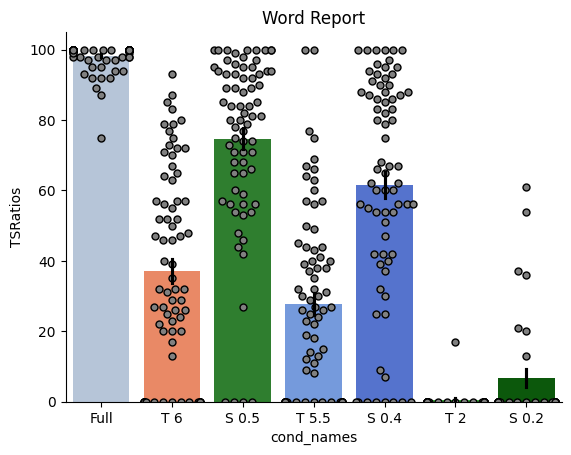

In [5]:


cols = ['royalblue', 'coral', 'forestgreen', "cornflowerblue", 'lightsteelblue', 'limegreen', 'darkgreen']

fig, ax = plt.subplots(1, 1)

ax = sns.swarmplot(x="cond_names", y="TSRatios", data=new_df, zorder=1, order=['Full', 'T 6', 'S 0.5', 'T 5.5', 'S 0.4', 'T 2', 'S 0.2'], color='grey', edgecolor='k', linewidth=1)
ax = sns.barplot(x="cond_names", y="TSRatios", data=new_df, hue='cond_names', err_kws={'color': 'k'}, zorder=0, order=['Full', 'T 6', 'S 0.5', 'T 5.5', 'S 0.4', 'T 2', 'S 0.2'], palette=cols, errorbar='se')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Word Report")

corr_intel_scores = np.corrcoef(new_df['intelligibility_rating'].values, new_df["scores"].values)[0][1]
corr_intel_ratio = np.corrcoef(new_df['intelligibility_rating'].values, new_df["TSRatios"].values)[0][1]
corr_scores_ratio = np.corrcoef(new_df['scores'].values, new_df["TSRatios"].values)[0][1]
print(corr_intel_scores, corr_intel_ratio, corr_scores_ratio)

In [7]:
new_df.to_csv("C:\\Users\\Jeremy\\Desktop\\Convergence\\data\\Filtered\\PILOT1\\df_allPILOT1.csv",index=None)

In [6]:
new_df

,words_typed,intelligibility_rating,audio,condition,cutoff,content,trial_index,fullcond,suj_id,scores,TSRatios,cond_names,colors
0,Charlie dont climb up the tree.,2,filter_Inf_0.4_frm01_s06.wav,Spectral,0.4,Charlie did you think to measure the tree,4,Spectral_0.4,1,4.878049,62,S 0.4,forestgreen
1,The anesethologist relaxed throughtout the voyage,4,filter_6_Inf_frm01_s28.wav,Temporal,6,The easygoing zoologist relaxed throughout the...,7,Temporal_6,1,5.660377,75,T 6,royalblue
2,I have arranged for a meeting at 2,4,filter_Inf_0.5_frm01_s24.wav,Spectral,0.5,If Carol comes tomorrow have her arrange for a...,10,Spectral_0.5,1,8.196721,65,S 0.5,darkgreen
3,The is a superb sleeping pill,3,filter_6_Inf_frm01_s12.wav,Temporal,6,A boring novel is a superb sleeping pill,13,Temporal_6,1,12.500000,72,T 6,royalblue
4,Jeff fought in favour of his purchase,3,filter_Inf_0.5_frm01_s16.wav,Spectral,0.5,Jeff thought you argued in favor of a centrifu...,16,Spectral_0.5,1,7.017544,57,S 0.5,darkgreen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,special task force is rescued...kidnappers,3,filter_Inf_0.5_frm01_s23.wav,Spectral,0.5,Special task forces rescue hostages from kidna...,133,Spectral_0.5,9,3.921569,84,S 0.5,darkgreen
44,play in the street up ahead,3,filter_Inf_0.4_frm01_s03.wav,Spectral,0.4,Play in the street up ahead,136,Spectral_0.4,9,22.222222,100,S 0.4,forestgreen
45,Â£,1,filter_5.5_Inf_frm01_s06.wav,Temporal,5.5,Charlie did you think to measure the tree,139,Temporal_5.5,9,0.000000,0,T 5.5,cornflowerblue
46,caught speeding,2,filter_Inf_0.4_frm01_s04.wav,Spectral,0.4,A fifth wheel caught speeding,142,Spectral_0.4,9,6.896552,68,S 0.4,forestgreen


C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 47.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 56.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 81.9% of the p

Text(0.5, 1.0, 'Word Report')

C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 47.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 56.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Jeremy\anaconda3\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 81.9% of the p

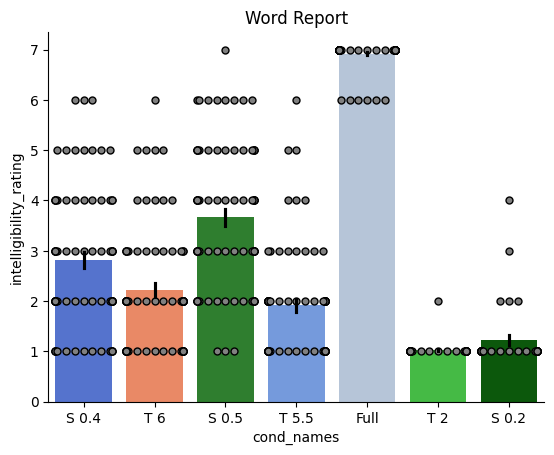

In [140]:
fig, ax = plt.subplots(1, 1)

ax = sns.swarmplot(x="cond_names", y="intelligibility_rating", data=new_df, zorder=1, color='grey', edgecolor='k', linewidth=1)
ax = sns.barplot(x="cond_names", y="intelligibility_rating", data=new_df, hue='cond_names', err_kws={'color': 'k'}, zorder=0,  palette=cols, errorbar='se')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Word Report")